# Heart Failure Prediction 

## We will predict heart failure rate using clustering and other various methods

### This notebook is made with the help of another Kaggle notebook submitted under the same task. The link to that notebook is :  https://www.kaggle.com/nayansakhiya/heart-fail-analysis-and-quick-prediction-96-rate

Importing necessary libraries

In [220]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from colorama import Fore, Back, Style
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm
from mlxtend.plotting import plot_confusion_matrix
import xgboost
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols

init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff

%matplotlib inline

Importing the csv file

In [221]:
data = pd.read_csv("../input/heart_failure_clinical_records_dataset.csv")
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Checking general information of the dataset

In [222]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


We noticed that many of the columns have binary values(1 or 0). They can be treated as category.

In [223]:
data['sex'] = data['sex'].astype('category')
data['diabetes'] = data['diabetes'].astype('category')
data['anaemia'] = data['anaemia'].astype('category')
data['high_blood_pressure'] = data['high_blood_pressure'].astype('category')
data['smoking'] = data['smoking'].astype('category')
data['DEATH_EVENT'] = data['DEATH_EVENT'].astype('category')

confirming the changes......

In [224]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       299 non-null    float64 
 1   anaemia                   299 non-null    category
 2   creatinine_phosphokinase  299 non-null    int64   
 3   diabetes                  299 non-null    category
 4   ejection_fraction         299 non-null    int64   
 5   high_blood_pressure       299 non-null    category
 6   platelets                 299 non-null    float64 
 7   serum_creatinine          299 non-null    float64 
 8   serum_sodium              299 non-null    int64   
 9   sex                       299 non-null    category
 10  smoking                   299 non-null    category
 11  time                      299 non-null    int64   
 12  DEATH_EVENT               299 non-null    category
dtypes: category(6), float64(3), int64(4)
memory usage:

We can see the changes that were reflected in the Dtype as well as the memory usage by the dataframe

At the initial stage, it was 30KB. Now, it came down to 18KB. So just by making necessary changes, we reduced the usage by 40%.

We can further investigate the data to optimize the data more.

In [225]:
data['age'].describe()

count    299.000000
mean      60.833893
std       11.894809
min       40.000000
25%       51.000000
50%       60.000000
75%       70.000000
max       95.000000
Name: age, dtype: float64

The age need not to be a float-point number. We can treat it as an integer.

In [226]:
data['age'] = data['age'].astype('int64')

We can further convert int64 to int32, int16 or even int8. But we have enough resources to overlook that. If the dataset was bigger, we would have considered doing so.

Now, we continue with our work.

Is Age and Sex an indicator for Death Event?

In [227]:
hist_data = [data['age'].values]
group_labels = ['age']

fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(title_text='Age Distribution')
fig.show()

We can see that from sub-40 to sub-70, there are huge number of people. 

In [228]:
fig = px.box(data, x='sex', y='age', points='all',)
fig.update_layout(
    title='Gender-wise Age Distribution',
    xaxis=dict(
    tickmode = 'array',
    tickvals = [1,0],
    ticktext = ['Male', 'Female']))
fig.show()

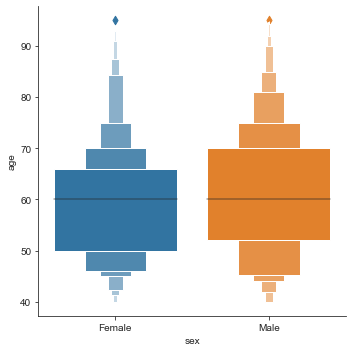

In [229]:
sns.set_style("ticks")
g = sns.catplot(x='sex', y='age', data=data, kind='boxen')
g.set_xticklabels(['Female', 'Male'])
#plt.show(ax, dpi = 200)

Evidently there are outliers in Male as well as Female. We will remove them if we find the need to in the future.

In [230]:
male = data[data['sex'] == 1]
female = data[data['sex'] == 0]

male_alive = male[male['DEATH_EVENT'] == 0]
male_dead = male[male['DEATH_EVENT'] == 1]
female_alive = female[female['DEATH_EVENT'] == 0]
female_dead = female[female['DEATH_EVENT'] == 1]

labels = ['Male - Survived', 'Male - Didn\'t survive', 'Female - Survived', 'Female - Didn\'t survive']
values = [len(male_alive), len(male_dead), len(female_alive), len(female_dead)]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.2)])
fig.update_layout(title="Gender-wise Survival Chart")
fig.show()

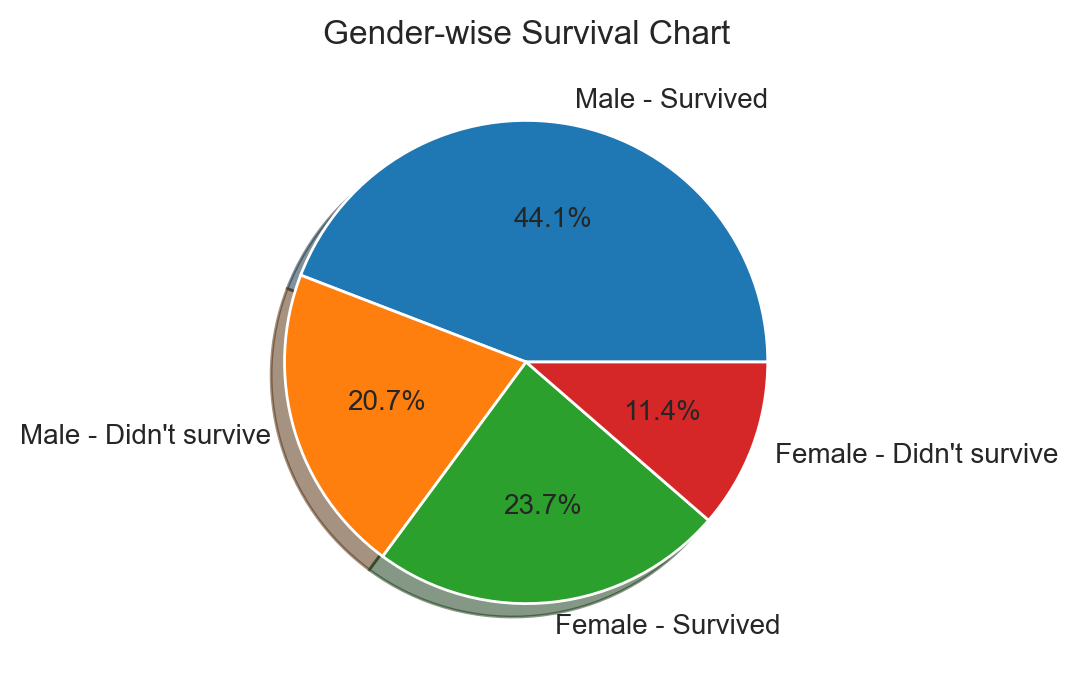

In [231]:
f, ax = plt.subplots(dpi=200)
ax = plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title("Gender-wise Survival Chart")
plt.show()

In [232]:
surv = pd.concat([male_alive, female_alive])
surv = surv['age']
dead = pd.concat([male_dead, female_dead])
dead = dead['age']

hist_data = [surv, dead]
group_labels = ['Survived', 'Didn\'t Survive']
fig = ff.create_distplot(hist_data, group_labels, bin_size=0.5)
fig.update_layout(title_text='Age-wise Survival state')
fig.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 <a list of 46 Text major ticklabel objects>)

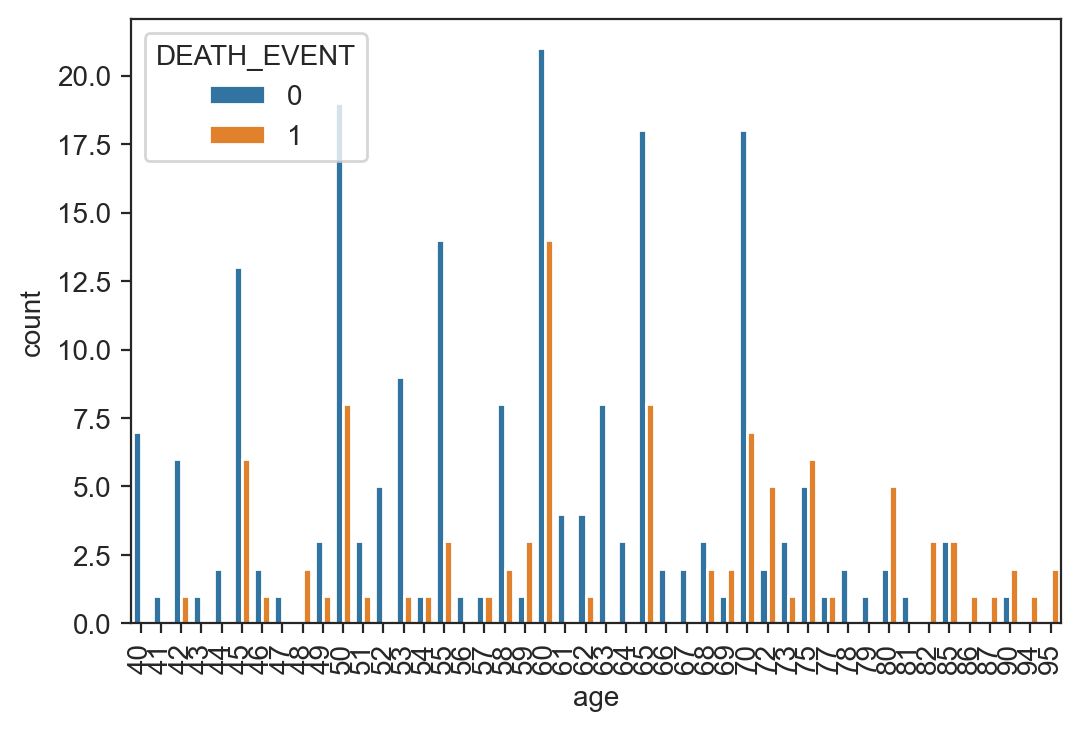

In [233]:
f, ax = plt.subplots(dpi=200)
ax = sns.countplot('age', data=data, hue='DEATH_EVENT')
plt.xticks(rotation=90)

In [234]:
fig = px.violin(data, y='age', x='sex', color='DEATH_EVENT', box=True, points="all", hover_data=data.columns)
fig.update_layout(title_text="Gender vs Age on survival status")

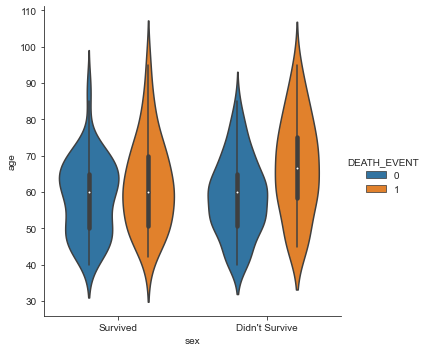

In [235]:
#f, ax = plt.subplots(dpi=200)
g = sns.catplot(x='sex', y='age', data=data, kind='violin', hue='DEATH_EVENT')
g.set_xticklabels(['Survived', 'Didn\'t Survive'])
#g.set_title("Sex vs Age Survival Status")


In [236]:
fig = px.violin(data, y='age', x='smoking', color='DEATH_EVENT', box=True, points="all", hover_data=data.columns)
fig.update_layout(title_text = 'Analysis in Age, Smoking and Survival status')
fig.show()

In [237]:
fig = px.box(data, y='age', x='diabetes', color='DEATH_EVENT', 
             notched=True, points='all', hover_data=data.columns, 
             title='Analysis in Age, Diabetes and Survival Status')
fig.show()

In [238]:
fig = px.histogram(data, x='creatinine_phosphokinase',
                  color='DEATH_EVENT', marginal='violin',
                  hover_data=data.columns,
                  title='Histogram for creatinine phosphokinase')
fig.show()

In [239]:
fig = px.histogram(data, x='ejection_fraction', color='DEATH_EVENT',
                  marginal='violin', hover_data=data.columns,
                  title='Histogram for Ejection Fraction')
fig.show()


In [240]:
fig = px.histogram(data, x='platelets', color='DEATH_EVENT',
                  marginal='violin', hover_data=data.columns,
                  title='Histogram for Platelets',
                  color_discrete_sequence=px.colors.sequential.Plasma)
fig.show()

In [241]:
fig = px.histogram(data, x='serum_creatinine', color='DEATH_EVENT',
                  marginal='violin', hover_data=data.columns,
                  title='Histogram for Serum Creatinine',
                  color_discrete_sequence=px.colors.diverging.PuOr)
fig.show()

In [242]:
fig = px.histogram(data, x='serum_sodium', color='DEATH_EVENT',
                  marginal='violin', hover_data=data.columns,
                  title='Histogram for Serum Sodium')
fig.show()

In [243]:
data = data.rename(columns={'DEATH_EVENT':'death'})

In [244]:
surv = data[data['death'] == 0]['serum_sodium']
dead = data[data['death'] == 1]['serum_sodium']
hist_data=[surv,dead]
labels = ['Survived', 'Didn\'t survive']

fig = ff.create_distplot(hist_data, labels, bin_size=0.5)
fig.update_layout(title_text='Serum Sodium vs Survival Status Analysis')
fig.show()

In [245]:
surv = data[data['death'] == 0]['serum_creatinine']
dead = data[data['death'] == 1]['serum_creatinine']

hist_data = [surv, dead]
labels = ['Survived', 'Didn\'t survive']

fig = ff.create_distplot(hist_data, labels, bin_size=0.5)
fig.update_layout(
    title_text='Serum Creatinine vs Survival Status Analysis')
fig.show()

In [246]:
surv = data[data['death'] == 0]['ejection_fraction']
dead = data[data['death'] == 1]['ejection_fraction']

hist_data = [surv, dead]
labels = ['Survived', 'Didn\'t survive']

fig = ff.create_distplot(hist_data, labels, bin_size=0.5)
fig.update_layout(
    title_text='Ejection Fraction vs Survival Status Analysis')
fig.show()

In [247]:
fig = px.pie(data, values='diabetes', names='death', 
             title='Diabetes x Death Chart')
fig.show()

In [248]:
dpos = data[data['diabetes'] == 1]
dneg = data[data['diabetes'] == 0]

labels = ['Positive Diabetes, Survived', 'Positive Diabetes, Didn\'t Survive',
         'Negative Diabetes, Survived', 'Negative Diabetes, Didn\'t Survive']
dposdneg = dpos[dpos['death'] == 0]
dposdpos = dpos[dpos['death'] == 1]
dnegdneg = dneg[dneg['death'] == 0]
dnegdpos = dneg[dneg['death'] == 1]

values = [len(dposdneg),
         len(dposdpos),
         len(dnegdneg),
         len(dnegdpos)]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.3)])
fig.update_layout(title_text='Survival x Diabetes Chart')
fig.show()

In [249]:
fig = px.pie(data, values='anaemia', names='death',
            title='Anaemia x Death Chart')
fig.show()

In [250]:
data.anaemia.describe()

count     299
unique      2
top         0
freq      170
Name: anaemia, dtype: int64

In [251]:
apos = data[data['anaemia'] == 1]
aneg = data[data['anaemia'] == 0]

aposdneg = apos[apos['death'] == 0]
aposdpos = apos[apos['death'] == 1]
anegdneg = aneg[aneg['death'] == 0]
anegdpos = aneg[aneg['death'] == 1]

labels = ['Positive Anaemia, Survived', 'Positive Anaemia, Didn\'t Survive',
         'Negative Anaemia, Survived', 'Negative Anaemia, Didn\'t Survive'] 

values = [len(aposdneg), len(aposdpos), len(anegdneg), len(anegdpos)]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.3)])
fig.update_layout(
    title_text='Survival x Anaemia Analysis'
)
fig.show()

In [252]:
fig = px.pie(data, values='smoking', names='death',
            title='Smoking x Death Chart')
fig.show()

In [253]:
apos = data[data['smoking'] == 1]
aneg = data[data['smoking'] == 0]

aposdneg = apos[apos['death'] == 0]
aposdpos = apos[apos['death'] == 1]
anegdneg = aneg[aneg['death'] == 0]
anegdpos = aneg[aneg['death'] == 1]

labels = ['Smoked, Survived', 'Smoked, Didn\'t Survive',
         'Didn\'t Smoke, Survived', 'Didn\'t Smoke, Didn\'t Survive'] 

values = [len(aposdneg), len(aposdpos), len(anegdneg), len(anegdpos)]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.3)])
fig.update_layout(
    title_text='Survival x Smoking Analysis'
)
fig.show()

In [254]:
fig = px.pie(data, values='high_blood_pressure', names='death',
            title='High Blood Pressure x Death Chart')
fig.show()

In [255]:
apos = data[data['high_blood_pressure'] == 1]
aneg = data[data['high_blood_pressure'] == 0]

aposdneg = apos[apos['death'] == 0]
aposdpos = apos[apos['death'] == 1]
anegdneg = aneg[aneg['death'] == 0]
anegdpos = aneg[aneg['death'] == 1]

labels = ['HBP, Survived', 'HBP, Didn\'t Survive',
         'Not HBP, Survived', 'Not HBP, Didn\'t Survive'] 

values = [len(aposdneg), len(aposdpos), len(anegdneg), len(anegdpos)]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.3)])
fig.update_layout(
    title_text='Survival x High Blood Pressure Analysis'
)
fig.show()

HEATMAP

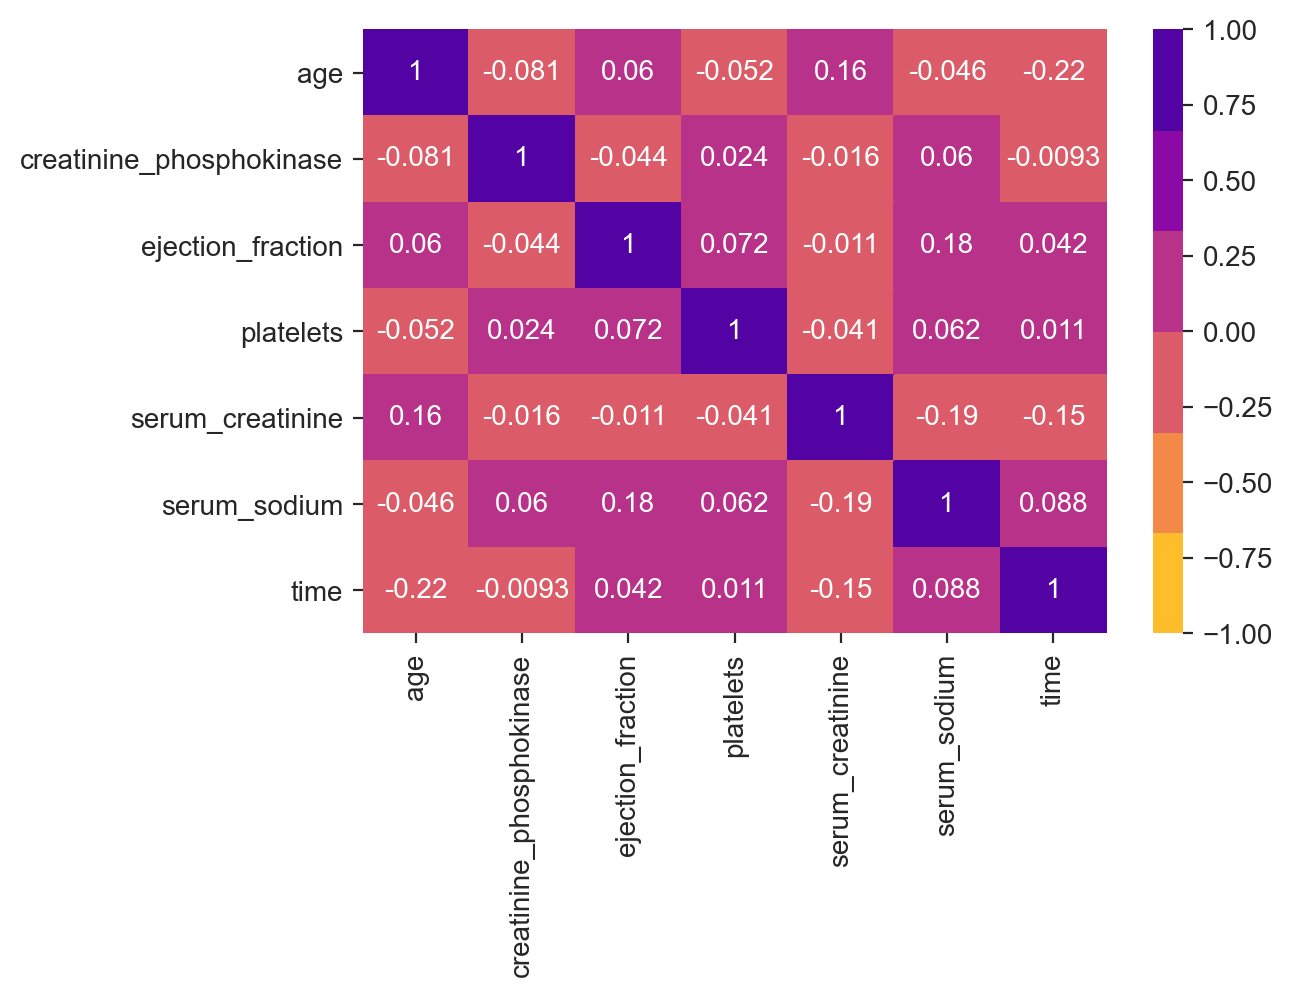

In [256]:
plt.figure(dpi=200)
sns.heatmap(data.corr(), vmin=-1, cmap=sns.color_palette("plasma_r"), annot=True)

In [257]:
#choice = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
index_vals = data['death'].cat.codes


fig = go.Figure(data=go.Splom(
    dimensions=[
        dict(label='Age', values=data['age']),
        dict(label='Creatinine Phosphokinase', values=data['creatinine_phosphokinase']),
        dict(label='Ejection Fration', values=data['ejection_fraction']),
        dict(label='Platelets', values=data['platelets']),
        dict(label='Serum Creatinine', values=data['serum_creatinine']),
        dict(label='Serum Sodium', values=data['serum_sodium'])    
    ],
    text=data['death']
))

fig.update_layout(
    title='Heart Failure Data set',
    dragmode='select',
    width=1000,
    height=1000,
    hovermode='closest',
)

fig.show()


## Let's do some data modelling 

In [258]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       299 non-null    int64   
 1   anaemia                   299 non-null    category
 2   creatinine_phosphokinase  299 non-null    int64   
 3   diabetes                  299 non-null    category
 4   ejection_fraction         299 non-null    int64   
 5   high_blood_pressure       299 non-null    category
 6   platelets                 299 non-null    float64 
 7   serum_creatinine          299 non-null    float64 
 8   serum_sodium              299 non-null    int64   
 9   sex                       299 non-null    category
 10  smoking                   299 non-null    category
 11  time                      299 non-null    int64   
 12  death                     299 non-null    category
dtypes: category(6), float64(2), int64(5)
memory usage:

In [259]:
features = ['diabetes', 'ejection_fraction', 'high_blood_pressure',
           'serum_creatinine', 'age', 'time']

features = ['time', 'age', 'ejection_fraction', 'serum_creatinine', 'platelets']

X = data[features]
y = data.death

##### Traint Test Split

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.2,
                                                   random_state=2698)

## Random Forest Classifier

In [261]:
clf = RandomForestClassifier(max_features=2, max_depth=15,
                            random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy of RandomForestClassifier is : ",
     clf.score(X_test, y_test))

Accuracy of RandomForestClassifier is :  0.95


<Figure size 432x288 with 0 Axes>

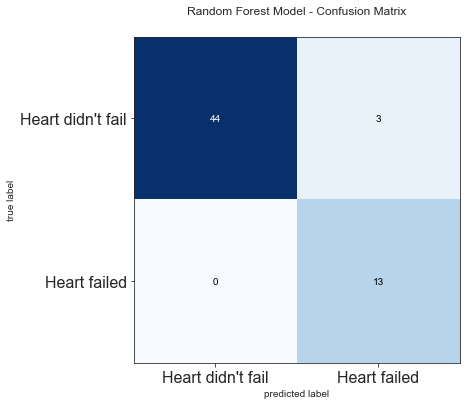

In [262]:
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(10,6), hide_ticks=True,
                     cmap = plt.cm.Blues)
plt.title("Random Forest Model - Confusion Matrix")
plt.xticks(range(2), ["Heart didn\'t fail", "Heart failed"],
          fontsize=16)
plt.yticks(range(2), ["Heart didn\'t fail", "Heart failed"],
          fontsize=16)
plt.show()

## GradientBoostingClassifier

In [263]:
gradientboost_clf = GradientBoostingClassifier(max_depth=2,
                                              random_state=4)
gradientboost_clf.fit(X_train, y_train)
gradientboost_pred = gradientboost_clf.predict(X_test)

print("Accuracy of Gradient Boosting is : ",
     gradientboost_clf.score(X_test, y_test))

Accuracy of Gradient Boosting is :  0.95


<Figure size 432x288 with 0 Axes>

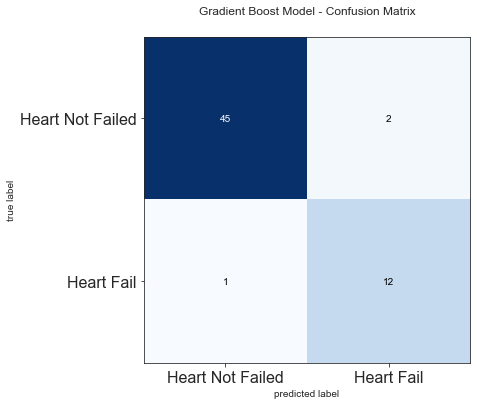

In [264]:
cm = confusion_matrix(y_test, gradientboost_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(10,6), hide_ticks=True,
                    cmap=plt.cm.Blues)
plt.title("Gradient Boost Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

## XGBRFClassifier

In [265]:
xgb_clf = xgboost.XGBRFClassifier(max_depth=3, random_state=0)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

print("Accuracy of XGBRFClassifier is : ", xgb_clf.score(X_test,
                                                        y_test))

Accuracy of XGBRFClassifier is :  0.9333333333333333


<Figure size 432x288 with 0 Axes>

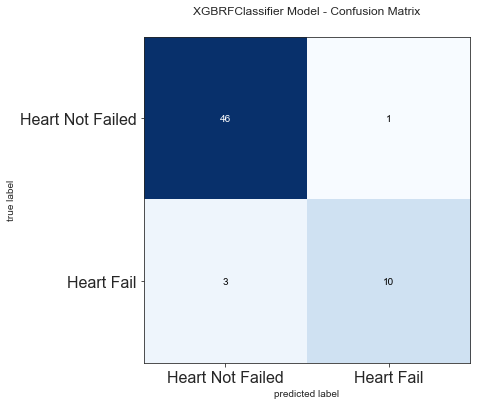

In [266]:
cm = confusion_matrix(y_test, xgb_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(10,6), hide_ticks=True,
                     cmap=plt.cm.Blues)
plt.title("XGBRFClassifier Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

## LGBMClassifier 

In [267]:
lgb_clf = lightgbm.LGBMClassifier(max_depth=2, random_state=1)
lgb_clf.fit(X_train, y_train)
lgb_pred = lgb_clf.predict(X_test)

print("Accuracy of LGBMClassifier is : ", 
     lgb_clf.score(X_test, y_test))

Accuracy of LGBMClassifier is :  0.9333333333333333


<Figure size 432x288 with 0 Axes>

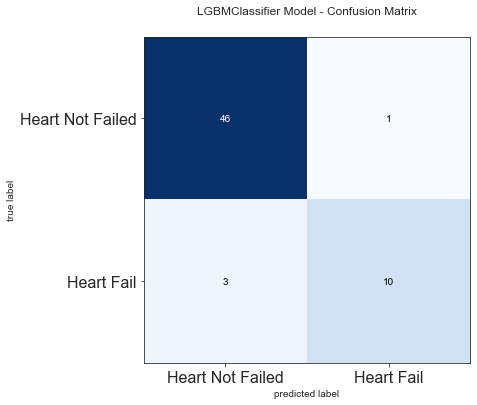

In [268]:
cm = confusion_matrix(y_test, lgb_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(10,6), hide_ticks=True,
                     cmap=plt.cm.Blues)
plt.title("LGBMClassifier Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

##  Results

<ol type='i'>
    <li>Random Forest Classifier : 95%</li>
    <li>Gradient Boosting Classifier : 95%</li>
    <li>Extreme Gradient Boosting RFClassifier : 93.33%</li>
    <li>Light Gradient Boosting Manner Classifier : 93.33%</li>
</ol>

## Thank you!
### Suggestions are welcomed. 

### :) 